<a href="https://colab.research.google.com/github/Thabby07/richter-predictor/blob/master/TFM_Entrenamiento_Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#pip install mord
pip install sklearn-contrib-py-earth
pip install keras
pip install tensorflow==2.0.0-beta

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from datetime import datetime
import mord
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [0]:
train = pd.read_csv('/content/train_processed.csv',sep=';').set_index('building_id')
test = pd.read_csv('/content/test_processed.csv',sep=';').set_index('building_id')

In [0]:
print(train.head(1))
print(test.head(1))

             geo_level_1_id  ...  legal_ownership_status_w
building_id                  ...                          
433870                   25  ...                         0

[1 rows x 69 columns]
             geo_level_1_id  ...  legal_ownership_status_w
building_id                  ...                          
300051                   17  ...                         0

[1 rows x 68 columns]


In [0]:
train['damage_grade'].value_counts().sort_index(ascending=True)

1     1600
2    18185
3     9588
Name: damage_grade, dtype: int64

Por tanto, del dataset procesado, el **grado 1** significa un **5.44%** del total, el **grado 2** un **61.91%** y el **grado 3** un **32.64%**.

In [0]:
X = train.drop(['damage_grade'], axis=1)
y = train['damage_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Random Forest

In [0]:
RF_classifier = RandomForestClassifier(n_estimators=150, min_samples_split=20, 
                                       max_features='sqrt',random_state=0)
RF_classifier.fit(X_train, y_train)
RF_pred = RF_classifier.predict(X_test)

In [0]:
f1_micro_score = f1_score(y_test, RF_pred, average='micro')
print(f1_micro_score)

0.7189787234042553


In [0]:
RF_pred = RF_classifier.predict(test)

In [0]:
test.reset_index(level=0, inplace=True)
output = pd.DataFrame({'building_id': test['building_id'], 
                       'damage_grade': RF_pred})

timestamp = str(np.rint(datetime.timestamp(datetime.now())).astype(int))

path = "/content/" + timestamp + "_RF_competition_result.csv"
output.to_csv(path_or_buf=path, index=False)

### Hiperparametrización del RF


In [38]:
param_dist = {#"n_estimators": [150], # Number of trees in random forest, tested previously
              "max_features": ['sqrt'], # Number of features to consider at every split
              "max_depth": [4,8,16], # Maximum number of levels in tree
              "min_samples_split": [20], #  Minimum number of samples required to split a node
              "min_samples_leaf": [5,10,15,25,30], # Minimum number of samples required at each leaf node
              "bootstrap": [True, False] # Method of selecting samples for training each tree
              #"criterion": ["mae"]
            }
n_iter_search = 20
# constructor
RF_classifier =  RandomForestClassifier(n_estimators=150, min_samples_split=20, 
                                       max_features='sqrt',random_state=0)

param_dist

{'bootstrap': [True, False],
 'max_depth': [4, 8, 16],
 'max_features': ['sqrt'],
 'min_samples_leaf': [5, 10, 15, 25, 30],
 'min_samples_split': [20]}

In [28]:
RF_classifier_randomized = RandomizedSearchCV(estimator=RF_classifier, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10)
#RF_classifier_grid = GridSearchCV(estimator=RF_classifier, param_grid=param_dist, cv=5)

# Fit the random search model
RF_classifier_randomized.fit(X = X_train, y = y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='sqrt',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=20,
                                                    min_weight_fraction_leaf=0.0,
             

In [0]:
RF_classifier_randomized.fit(X_train, y_train)
RF_pred_rd = RF_classifier_randomized.predict(X_test)

In [36]:
f1_micro_score = f1_score(y_test, RF_pred_rd, average='micro')
print(f1_micro_score)

0.7096170212765958


A priori, parece que la métrica baja un poco. Veamos con la muestra real de test.

In [29]:
best_rf_rd_classifier = RF_classifier_randomized.best_estimator_
best_rf_rd_classifier

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
#Ajustamos el modelo sobre toda la muestra
best_rf_rd_classifier.fit(X = train.drop(['damage_grade'], axis=1), y = train['damage_grade'])
y_pred_opt_rs = best_rf_rd_classifier.predict(X = test)

In [31]:
best_rf_rd_classifier.feature_importances_

array([0.41654722, 0.23272224, 0.17114465, 0.        , 0.05320408,
       0.06419544, 0.05061157, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01157479, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [32]:
# Ocurrencias
unique, counts = np.unique(y_pred_opt_rs, return_counts=True)
dict(zip(unique, counts))

{1: 92, 2: 73130, 3: 13646}

In [0]:
test.reset_index(level=0, inplace=True)
output = pd.DataFrame({'building_id': test['building_id'], 
                       'damage_grade': y_pred_opt_rs})

timestamp = str(np.rint(datetime.timestamp(datetime.now())).astype(int))

path = "/content/" + timestamp + "_RF_hiperparam_competition_result.csv"
output.to_csv(path_or_buf=path, index=False)

Es mejor el primer modelo del RamdonForest así que inspeccionamos las variables más importantes:

Enlace de interés https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e


In [0]:
feature_importances = pd.DataFrame(RF_classifier.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 ascending=False)

In [44]:
feature_importances[feature_importances['importance'] > 0.0]

,importance
geo_level_1_id,0.307613
geo_level_2_id,0.243525
geo_level_3_id,0.213218
area_percentage,0.086448
age,0.080472
height_percentage,0.058715
has_superstructure_timber,0.010011


## Redes neuronales

### KERAS

Enlaces de interés:

https://medium.com/neuron4/introducci%C3%B3n-al-deep-learning-con-keras-b51c47560565

In [0]:
#TODO Vamos a borrar las variables geograficas por probar
train = train.drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1)
test = test.drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1)

In [0]:
# BORRAMOS EL REGISTRO CON BUILDING ID  811. AVERIGUAR POR QUE NO MAPEA
X = train.drop(['damage_grade'], axis=1).dropna()
y = train[['damage_grade']].dropna()

In [0]:
# Keras espera el target como una variable que expresa la probabilidad de que sea cierta o no
# Es decir, nuestro target serán 3 variables, damage_grade_1, iden_2, idem_3
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder() 
y = onehotencoder.fit_transform(y).toarray()
y = pd.DataFrame(y)
y.columns = ['damage_grade_1','damage_grade_2','damage_grade_3']
y['damage_grade_1'] = y['damage_grade_1'].astype('int64')
y['damage_grade_2'] = y['damage_grade_2'].astype('int64')
y['damage_grade_3'] = y['damage_grade_3'].astype('int64')

In [0]:
# Comprobamos que no ha variado la muestra tras realizar el 'one hot encoding'.
#1    25124
#2    148259
#3    87218
print(y['damage_grade_1'].sum())
print(y['damage_grade_2'].sum())
print(y['damage_grade_3'].sum())

25124
148259
87218


In [0]:
def get_f1(y_true, y_pred): #taken from old keras source code
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    y_true = tf.convert_to_tensor(y_true, np.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [0]:
# Calculate target class  weight
from sklearn.utils import class_weight, compute_class_weight
from sklearn.utils.class_weight import compute_class_weight


weights = class_weight.compute_sample_weight('balanced', y)


In [0]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
import keras.backend as K
from keras import regularizers 
from keras.metrics import categorical_accuracy

# define the keras model
model = Sequential()
# 12 8 3 get_f1  Accuracy: 57.08 - same predictions
# 25 12 3 get_f1 Accuracy: 56.89 - same predictions
# 25 3 get_f1    Accuracy: 56.89 - same predictions
# 8 8 3 get_f1   Accuracy: 57.04 - same predictions

# 8 8 3 accuracy                     Accuracy: 71.46
# 8 8 3 accuracy + cat_crossentropy  Accuracy: 56.89
# 128 64 32                          Accuracy: 39.76
# 8 3                                Accuracy: 71.54                             
# 8 3 sigmoid                        Accuracy: 71.26
# 8 3 dropout (1)                    Accuracy: 71.26
# 8 3 dropout (1)  / l2 regu         Accuracy: 71.26
# 8 3 dropout (1)  / l2 regu categorical_accuracy  Accuracy: 56.89
# 16 3 dropout (1) / l2 regu         Accuracy: 71.26  
# 16 3 dropout (1) / l2 regu + no geo info    Accuracy: 72.05     
# 16 3 dropout (1) / l2 regu + no geo info + weight target   Accuracy: 72.33


#model.add(Dropout(0.5))
cols_number = 65
model.add(Dense(16, input_dim=cols_number, activation='relu', kernel_regularizer=regularizers.l2(0.0015)))
model.add(Dropout(0.15))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
# compile the keras model
# TODO First, accuracy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=5, class_weight=weights, batch_size=10)

Epoch 1/5
260601/260601 [==============================] - 37s 141us/step - loss: 0.5236 - acc: 0.7155
Epoch 2/5
260601/260601 [==============================] - 36s 139us/step - loss: 0.5081 - acc: 0.7204
Epoch 3/5
260601/260601 [==============================] - 37s 141us/step - loss: 0.5073 - acc: 0.7203
Epoch 4/5
260601/260601 [==============================] - 37s 141us/step - loss: 0.5073 - acc: 0.7205
Epoch 5/5
260601/260601 [==============================] - 36s 140us/step - loss: 0.5070 - acc: 0.7208


In [0]:
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

260601/260601 [==============================] - 6s 24us/step
Accuracy: 72.33


In [0]:
predicted = model.predict(test)
type(predicted)

numpy.ndarray

In [0]:
np.unique(predicted) # Wrong!! Returns always the same prob

array([0.00305241, 0.00321513, 0.00349432, ..., 0.8698186 , 0.87245464,
       0.87306696], dtype=float32)

In [0]:
predicted = pd.DataFrame(predicted)
predicted.columns = ['damage_grade_1','damage_grade_2','damage_grade_3']
# Asignamos una categoria final según la distribución de probabilidad de la función de activación final.

df_compared = pd.DataFrame(predicted.idxmax(axis=1))
df_compared.columns = ['damage_grade']
df_compared.groupby('damage_grade').size()


damage_grade
damage_grade_1     4852
damage_grade_2    78712
damage_grade_3     3304
dtype: int64

In [0]:
keras_pred = df_compared.replace(to_replace=r'damage_grade_*', value='', regex=True).astype('int64').to_numpy().flatten()


array([2, 2, 2, ..., 2, 2, 2])

In [0]:
test.reset_index(level=0, inplace=True)

In [0]:
output = pd.DataFrame({'building_id': test['building_id'], 
                       'damage_grade': keras_pred})

timestamp = str(np.rint(datetime.timestamp(datetime.now())).astype(int))

path = "/content/" + timestamp + "_kerasNN_competition_result.csv"
output.to_csv(path_or_buf=path, index=False)

In [0]:
keras_pred.to_numpy()

array([[2],
       [2],
       [2],
       ...,
       [2],
       [2],
       [2]])

### *Pytorch* (DEPRECATED)

Source: https://www.ethanrosenthal.com/2018/12/06/spacecutter-ordinal-regression/

In [0]:
#pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from datetime import datetime

In [0]:
train_values = pd.read_csv('/content/train_values.csv')
train_labels = pd.read_csv('/content/train_labels.csv')
test_values = pd.read_csv('/content/test_values.csv')
train = train_values.set_index('building_id').join(train_labels.set_index('building_id'), how='left')
train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


Vamos a eliminar las **variables identificadores geográficas**.

In [0]:
X = train.drop(columns=['damage_grade','geo_level_1_id','geo_level_2_id','geo_level_3_id']).dropna()
y = train[['damage_grade']].dropna()

Es necesario convertir las variables categóricas a numericas y luego tensorizar todas las variables (numericas + categoricas).


In [0]:
categorical_columns = X.select_dtypes('object').columns
numerical_columns = X.select_dtypes('int64').columns

In [0]:
for category in categorical_columns:
    X[category] = X[category].astype('category')

In [0]:
categorical_data = np.stack([X[col].cat.codes.values for col in categorical_columns], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

In [0]:
numerical_data = np.stack([X[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

In [0]:
outputs = torch.tensor(y['damage_grade'].values).flatten()
outputs

tensor([3, 2, 3,  ..., 3, 2, 3])

In [0]:
print(categorical_data.shape)
print(numerical_data.shape)
print(outputs.shape)

torch.Size([260601, 8])
torch.Size([260601, 27])
torch.Size([260601])


However, a better way is to represent values in a categorical column is in the form of an N-dimensional vector, instead of a single integer. A vector is capable of capturing more information and can find relationships between different categorical values in a more appropriate way. Therefore, we will represent values in the categorical columns in the form of N-dimensional vectors. This process is called **embedding**.

In [0]:
categorical_column_sizes = [len(X[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(3, 2), (5, 3), (3, 2), (5, 3), (4, 2), (4, 2), (10, 5), (4, 2)]


In [0]:
total_records = X.shape[0]
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

In [0]:
print(len(categorical_train_data))
print(len(numerical_train_data))
print(len(train_outputs))

print(len(categorical_test_data))
print(len(numerical_test_data))
print(len(test_outputs))

208481
208481
208481
52120
52120
52120


In [0]:
np.unique(outputs)

array([1, 2, 3])

In [0]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            # calculate dot product between inputs and weights
            all_layers.append(nn.Linear(input_size, i))
            # activation function
            all_layers.append(nn.ReLU(inplace=True))
            # apply batch normalization to the numerical columns
            all_layers.append(nn.BatchNorm1d(i))
            # avoid overfitting
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [0]:
output_size = np.unique(outputs).size
hidden_layers_neurons = [50] #[200,100,50]
model = Model(categorical_embedding_sizes, numerical_data.shape[1], output_size, hidden_layers_neurons, p=0.4)

In [0]:
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(5, 3)
    (2): Embedding(3, 2)
    (3): Embedding(5, 3)
    (4): Embedding(4, 2)
    (5): Embedding(4, 2)
    (6): Embedding(10, 5)
    (7): Embedding(4, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=48, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=3, bias=True)
  )
)


Una vez creado el modelo vamos a definir la función de pérdida (de momento, **CrossEntropyLoss** *pero habrá que cambiarla* - para target no binario) y la función de optimización (**adam optimizer**). 

In [0]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. 0 <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    
    '''
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1

In [0]:
#loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
epochs = 300
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    single_loss = f1_loss(train_outputs, y_pred,is_training=True)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 1.40321541
epoch:  26 loss: 1.40191722
epoch:  51 loss: 1.40525901
epoch:  76 loss: 1.40059328
epoch: 101 loss: 1.40354681
epoch: 126 loss: 1.40235507
epoch: 151 loss: 1.40055835
epoch: 176 loss: 1.40380335
epoch: 201 loss: 1.40440142
epoch: 226 loss: 1.40474999
epoch: 251 loss: 1.40242434
epoch: 276 loss: 1.40346122
epoch: 300 loss: 1.4021377563


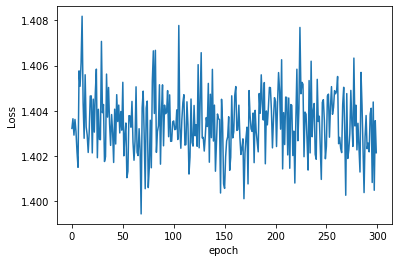

In [0]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

Evaluamos con el dataset de test que salió del entrenamiento.

In [0]:
with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = f1_loss(test_outputs, y_val)
print(f'Loss: {loss:.8f}')
print(np.argmax(y_val, axis=1))

Loss: 1.40165603
tensor([2, 1, 1,  ..., 2, 0, 2])


Evaluamos sobre el conjunto de test original para la competición, pero antes debemos tratar las variables igual que hicimos con el entrenamiento.


In [0]:
t = test.drop(columns=['geo_level_1_id','geo_level_2_id','geo_level_3_id']).dropna()
test_categorical_columns = t.select_dtypes('object').columns
test_numerical_columns = t.select_dtypes('int64').columns
for category in test_categorical_columns:
    t[category] = t[category].astype('category')
test_categorical_data = np.stack([t[col].cat.codes.values for col in test_categorical_columns], 1)
test_categorical_data = torch.tensor(test_categorical_data, dtype=torch.int64)
test_numerical_data = np.stack([t[col].values for col in test_numerical_columns], 1)
test_numerical_data = torch.tensor(test_numerical_data, dtype=torch.float)

with torch.no_grad():
    test_val = model(test_categorical_data, test_numerical_data)
print(test_val[:5])

Loss: 1.26852286
tensor([[-0.1914,  0.1720,  0.2634],
        [ 0.0294, -0.5036, -0.4244],
        [ 0.1353,  0.2273, -0.2545],
        [-1.0235,  0.1815,  0.0457],
        [-0.8245, -0.6699,  0.9151]])


In [0]:
test_val = np.argmax(test_val, axis=1)

In [0]:
np.unique(train.damage_grade)

array([1, 2, 3])

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))
print(f1_score(test_outputs, y_val, average = 'micro'))

[[    0     0     0     0]
 [ 1645  1267  2132     0]
 [13145  6429 10051     0]
 [ 8031  3738  5682     0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.11      0.25      0.15      5044
           2       0.56      0.34      0.42     29625
           3       0.00      0.00      0.00     17451

    accuracy                           0.22     52120
   macro avg       0.17      0.15      0.14     52120
weighted avg       0.33      0.22      0.26     52120

0.2171527244819647
0.2171527244819647


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
y_val.numpy()

array([2, 2, 0, ..., 2, 0, 1])

In [0]:
output = pd.DataFrame({'building_id': test['building_id'], 
                       'damage_grade': y_val.numpy()})

timestamp = str(np.rint(datetime.timestamp(datetime.now())).astype(int))

path = "/content/" + timestamp + "_RF_competition_result.csv"
output.to_csv(path_or_buf=path, index=False)

## *Red neuronal - sklearn* (DEPRECATED)

In [0]:
test = test.drop(['building_id'], axis=1)
test.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'land_surface_condition_n',
       'land

In [0]:
from sklearn.neural_network import MLPClassifier
#https://scikit-learn.org/stable/modules/neural_networks_supervised.html

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X, y)
#MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
#              solver='lbfgs')

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [0]:
# Revisar por que me predice solo una de las categorias.
y_pred = clf.predict(test)
np.unique(y_pred)

array([3])